## Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

## Uncertain Space

In [4]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [ ]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':100004.412,'n_pax':120.0,'area':109.205,'ar':14.528,'fuel_type':'kerosene','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [7]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 17:48:56: *** Start Sampling execution ***
    INFO - 17:48:56: Sampling
    INFO - 17:48:56:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:48:56:    MDO formulation: MDF
    INFO - 17:48:56: Running the algorithm OT_MONTE_CARLO:


    INFO - 17:48:58:    100%|██████████| 100/100 [00:02<00:00, 34.73 it/sec]
    INFO - 17:48:58: *** End Sampling execution (time: 0:00:02.896905) ***


In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [10]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.99931484]),
 'length': array([nan]),
 'mtom': array([0.99913399]),
 'span': array([1.]),
 'tofl': array([0.99913224]),
 'vapp': array([0.99910606]),
 'vz': array([0.99942436])}

In [11]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([3.68219321e-17]),
 'length': array([0.]),
 'mtom': array([5.63593253e-12]),
 'span': array([0.]),
 'tofl': array([7.87645516e-14]),
 'vapp': array([6.02915504e-15]),
 'vz': array([6.1534806e-16])}

In [12]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.00034361]),
 'length': array([0.]),
 'mtom': array([8.60637556]),
 'span': array([0.]),
 'tofl': array([0.49525862]),
 'vapp': array([0.00517117]),
 'vz': array([0.00223611])}

In [13]:
from matplotlib import pyplot as plt

from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [14]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00788825]),
 'cef': array([1.00629333]),
 'fm': array([0.50918795]),
 'length': array([32.]),
 'mtom': array([63512.65186885]),
 'sef': array([1.00791544]),
 'span': array([39.83127214]),
 'tofl': array([1921.40004914]),
 'vapp': array([66.66833433]),
 'vz': array([4.72191589])}

In [15]:
variance = statistics.compute_variance()
variance

{'aef': array([7.37077678e-05]),
 'cef': array([8.44338002e-05]),
 'fm': array([0.00017232]),
 'length': array([0.]),
 'mtom': array([85529.99534381]),
 'sef': array([7.1277677e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([282.65996246]),
 'vapp': array([0.02991358]),
 'vz': array([0.00868639])}

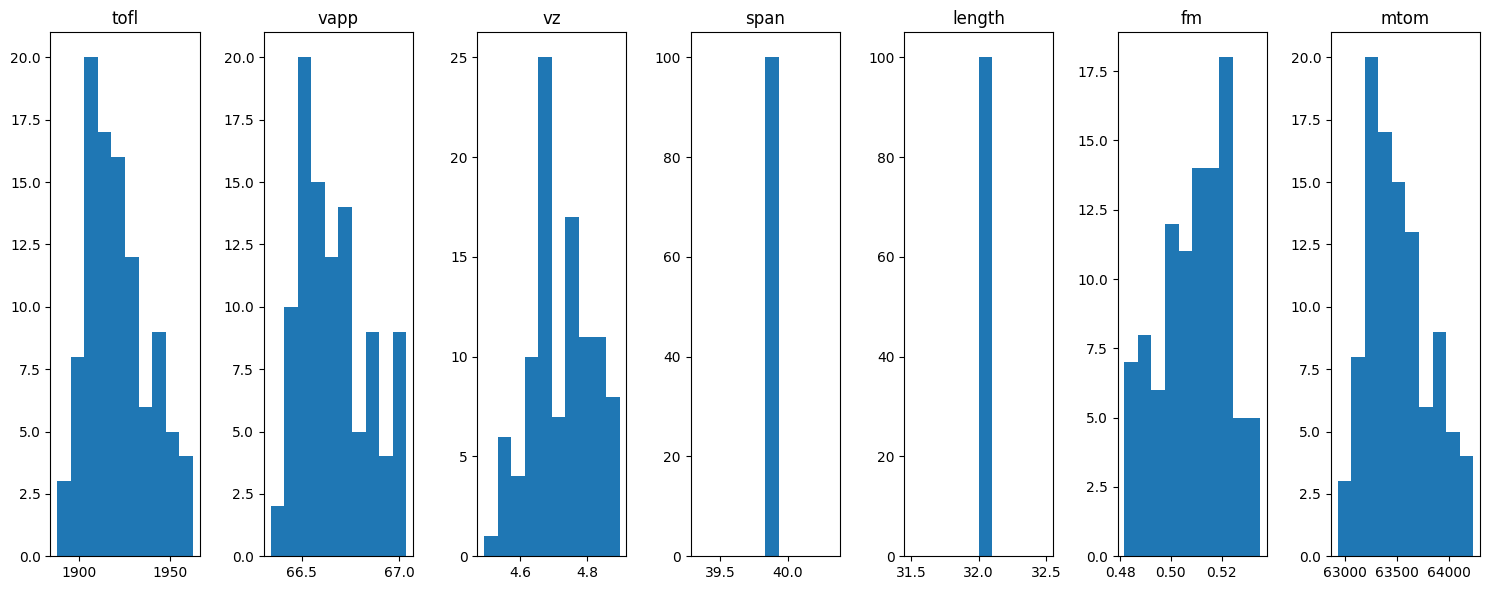

In [16]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [17]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [18]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 1000)

 WARNING - 17:49:01: No coupling in MDA, switching chain_linearize to True.
    INFO - 17:49:01: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 17:49:01: SobolAnalysisSamplingPhase
    INFO - 17:49:01:    Disciplines: RBF_Sampling
    INFO - 17:49:01:    MDO formulation: MDF
    INFO - 17:49:01: Running the algorithm OT_SOBOL_INDICES:
    INFO - 17:49:12:    100%|██████████| 1000/1000 [00:10<00:00, 92.88 it/sec]
    INFO - 17:49:12: *** End SobolAnalysisSamplingPhase execution (time: 0:00:10.834257) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.007311  0.995436  0.505371   32.0  63122.786402   
1          0.996470  1.000397  1.005658  0.525380   32.0  63312.850935   
2          1.012159  1.025222  1.010838  0.480947   32.0  63832.152295   
3          0.999643  1.004268  1.000353  0.517609   32.0  63194.837409   
4          0.999603  1.015163  1.013053  0.502628   32.0  63734.282558   
..              ...       ...       ...       ...    ...           ...   
995        0.991786  0.998037  1.013324  0.531231   32.0  63522.489055   
996        0.996654  0.997124  1.022199  0.529885   32.0  63833.991866   
997        1.015290  1.003540  1.019531  0.507723   32.0  63910.381106   
998        0.992562  1.025659  1.001652  0.492914   32.0  63426.866444   
999        1.008459  1.007255  1.004581  0.507317   32.0  63414.574722   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          39.831272  1899.040746  66.411127  4.800559  
1          39.831272  1909.904227  66.622140  4.834916  
2          39.831272  1939.765331  66.729290  4.619174  
3          39.831272  1903.154777  66.513377  4.846810  
4          39.831272  1934.109767  66.773987  4.712335  
..               ...          ...        ...       ...  
995        39.831272  1921.937525  66.777724  4.805451  
996        39.831272  1939.863781  66.962265  4.703828  
997        39.831272  1944.274292  66.905975  4.581863  
998        39.831272  1916.437347  66.538446  4.827536  
999        39.831272  1915.733231  66.599990  4.742823  

[1000 rows x 10 columns]

In [19]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'aef': array([0.07446691]), 'cef': array([0.11991481]), 'sef': array([1.0210764])}], 'vapp': [{'aef': array([0.01050109]), 'cef': array([0.00788682]), 'sef': array([1.19758801])}], 'vz': [{'aef': array([0.39054661]), 'cef': array([0.0766373]), 'sef': array([0.58334127])}], 'fm': [{'aef': array([0.1667766]), 'cef': array([0.82946021]), 'sef': array([0.00477858])}], 'mtom': [{'aef': array([0.07383223]), 'cef': array([0.11916241]), 'sef': array([1.02077717])}]}, second={'tofl': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07275178]]), 'sef': array([[-0.09346683]])}, 'cef': {'aef': array([[-0.07275178]]), 'cef': array([[0.]]), 'sef': array([[0.00508567]])}, 'sef': {'aef': array([[-0.09346683]]), 'cef': array([[0.00508567]]), 'sef': array([[0.]])}}], 'vapp': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.01970529]]), 'sef': array([[-0.01632731]])}, 'cef': {'aef': array([[-0.01970529]]), 'cef': array([[0.]]), 'sef': array([[-0.0157472

In [20]:
import pprint

In [21]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([0.1667766]),
         'cef': array([0.82946021]),
         'sef': array([0.00477858])}],
 'mtom': [{'aef': array([0.07383223]),
           'cef': array([0.11916241]),
           'sef': array([1.02077717])}],
 'tofl': [{'aef': array([0.07446691]),
           'cef': array([0.11991481]),
           'sef': array([1.0210764])}],
 'vapp': [{'aef': array([0.01050109]),
           'cef': array([0.00788682]),
           'sef': array([1.19758801])}],
 'vz': [{'aef': array([0.39054661]),
         'cef': array([0.0766373]),
         'sef': array([0.58334127])}]}
{'fm': [{'aef': array([0.18523229]),
         'cef': array([0.80702696]),
         'sef': array([-0.00051558])}],
 'mtom': [{'aef': array([0.03480435]),
           'cef': array([0.07392478]),
           'sef': array([0.86607082])}],
 'tofl': [{'aef': array([0.0348289]),
           'cef': array([0.07360576]),
           'sef': array([0.86575096])}],
 'vapp': [{'aef': array([-0.00409261]),
           'cef': array([-0.0

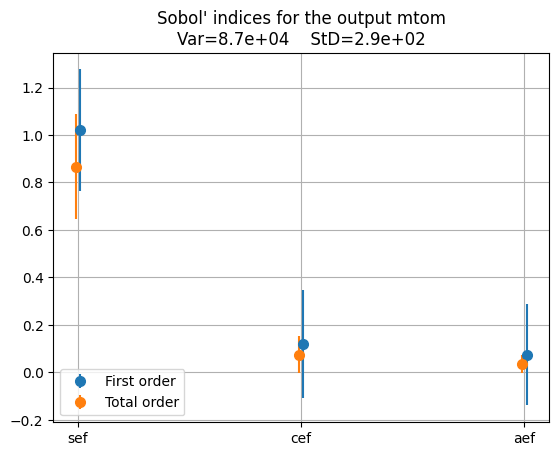

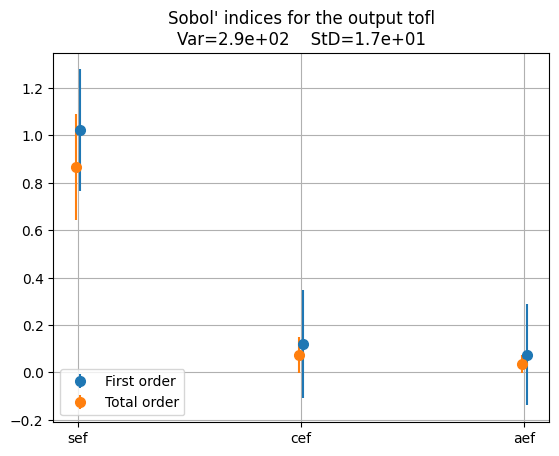

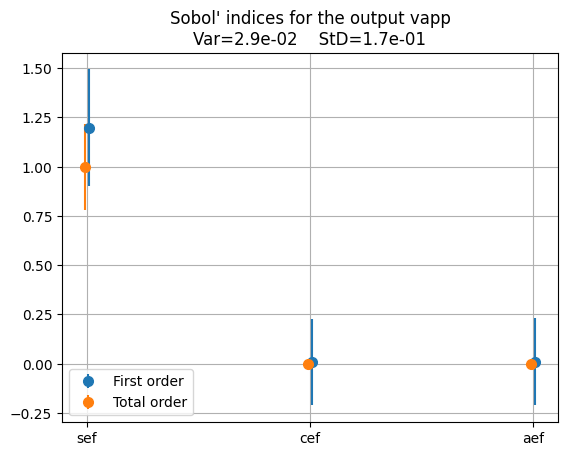

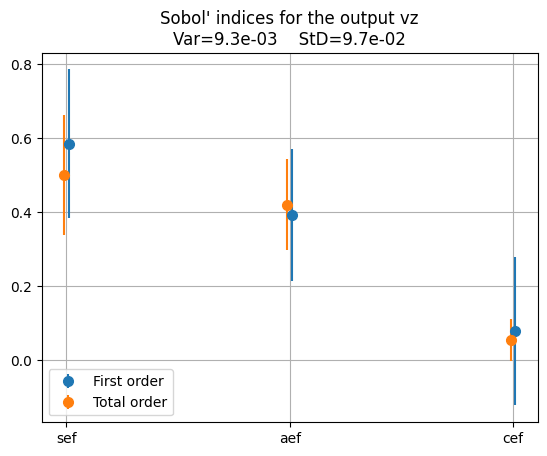

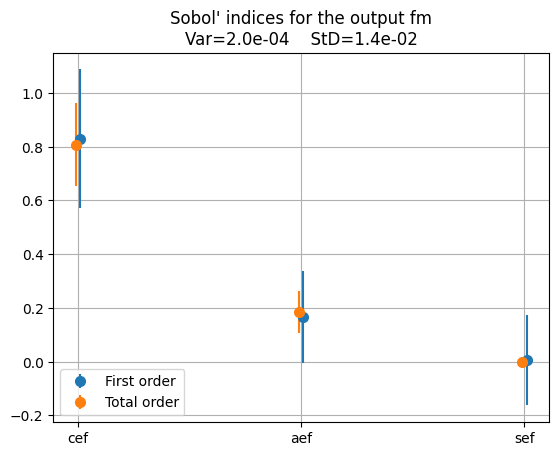

In [22]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))



